## NVIDIA (NVDA) - Last 3 Months Price & Event Analysis

My code downloads NVIDIA (NVDA) **daily** price data for the last 3 months, performs exploratory data analysis, plots prices and returns, and annotates firm-specific events (earnings release, SEC filings, analyst notes, sector news) that may explain price moves.  
NOTE: `yfinance` is being used to fetch price data (internet required).

In [1]:
try:
    import yfinance as yf
except Exception:
    import sys
    !{sys.executable} -m pip install yfinance --quiet
    import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta

plt.rcParams['figure.figsize'] = (12,6)

#### Daily Price Analysis

In [55]:
# Download last 3 months of daily data for NVDA
end = datetime.today().date()
start = (end - relativedelta(months=3)).replace(day=1)
ticker = yf.Ticker('NVDA')
df = ticker.history(start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'), interval='1d', actions=False)
df = df[['Open','High','Low','Close','Volume']].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2025-06-02,135.472955,138.102614,135.382955,137.362717,197663100
2025-06-03,138.762529,141.982125,137.932632,141.202225,225578800
2025-06-04,142.172116,142.372087,139.522440,141.902145,167120800
2025-06-05,142.152115,143.981887,138.812539,139.972397,231397900
2025-06-06,142.492058,143.251972,141.492183,141.702164,153986200


In [119]:
# Basic analysis: daily returns, cumulative returns, simple stats
df['Return'] = df['Close'].pct_change()
df['LogReturn'] = (df['Close'] / df['Close'].shift(1)).apply(lambda x: np.log(x) if pd.notnull(x) else x)
summary = df['Return'].describe()
cumulative_return = (df['Close'].iloc[-1] / df['Close'].iloc[0] - 1)
print('Period start:', df.index[0].date(), 'end:', df.index[-1].date())
print(f"Cumulative return over period: {cumulative_return:.2%}")
print('\nReturn summary:')
print(summary)

Period start: 2025-06-02 end: 2025-09-11
Cumulative return over period: 28.98%

Return summary:
count    70.000000
mean      0.003779
std       0.016691
min      -0.034998
25%      -0.006671
50%       0.004977
75%       0.013058
max       0.043340
Name: Return, dtype: float64


Mean return is 0.38%  
Cumulative return is 28.98%

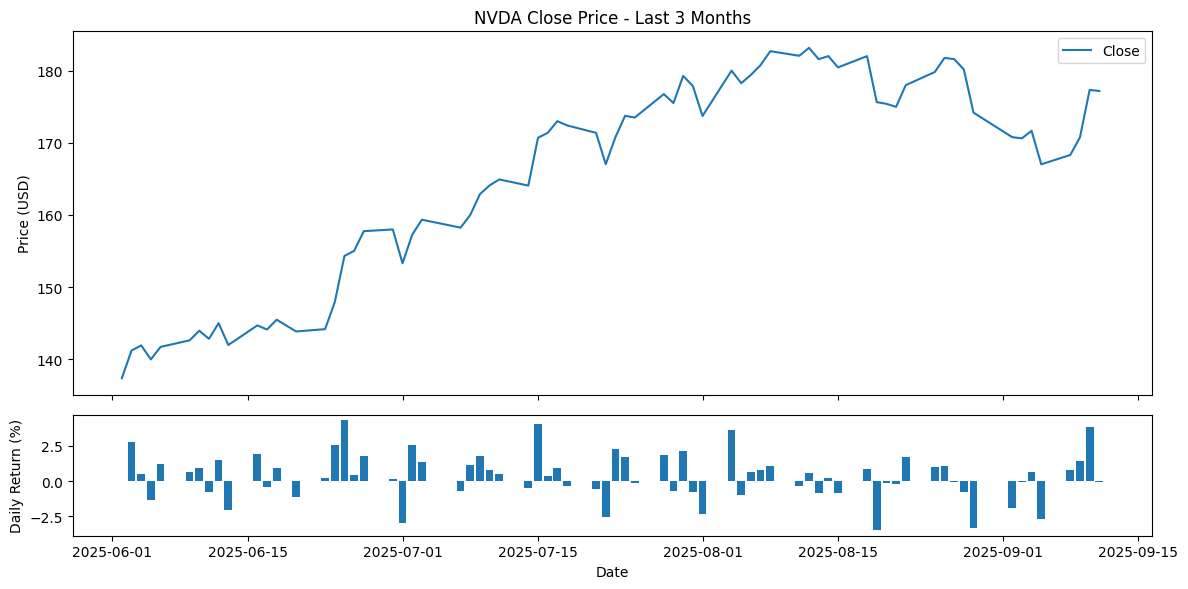

In [4]:
# Plot closing price and daily returns
fig, ax = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios':[3,1]})
ax[0].plot(df.index, df['Close'], label='Close')
ax[0].set_ylabel('Price (USD)')
ax[0].set_title('NVDA Close Price - Last 3 Months')
ax[0].legend()

ax[1].bar(df.index, df['Return']*100)
ax[1].set_ylabel('Daily Return (%)')
ax[1].set_xlabel('Date')
plt.tight_layout()
plt.show()

Price shows uptrend from June to Mid Aug 2025, slight downtrend from Mid Aug to Mid Sep 2025.

#### Financial Statements

##### Income Statement

In [92]:
is_df = ticker.quarterly_income_stmt.loc[['Total Revenue','Cost Of Revenue','Gross Profit','Operating Expense','Operating Income','EBIT','EBITDA','Net Income']] / 1_000_000
is_df.style.format("{:,.0f}").set_caption("Income Statement (Figures in Millions USD)")

,2025-07-31 00:00:00,2025-04-30 00:00:00,2025-01-31 00:00:00,2024-10-31 00:00:00,2024-07-31 00:00:00,2024-01-31 00:00:00
Total Revenue,"46,743","44,062","39,331","35,082","30,040",nan
Cost Of Revenue,"12,890","17,394","10,608","8,926","7,466",nan
Gross Profit,"33,853","26,668","28,723","26,156","22,574",nan
Operating Expense,"5,413","5,030","4,689","4,287","3,932",nan
Operating Income,"28,440","21,638","24,034","21,869","18,642",nan
EBIT,"31,268","21,973","25,278","22,377","19,275",nan
EBITDA,"31,937","22,584","25,821","22,855","19,708",nan
Net Income,"26,422","18,775","22,091","19,309","16,599",nan


Revenue of USD 46.74b beat estimated USD 46.06b (CNBC). There is healthy growth in Total Revenue and Net Income in the quarter ended July 2025. This bullish information was released on 27 Aug 2025 (more details later on).

##### EPS

In [139]:
ticker.quarterly_income_stmt.loc[['Basic EPS','Diluted EPS']]

,2025-07-31,2025-04-30,2025-01-31,2024-10-31,2024-07-31,2024-01-31
Basic EPS,1.08,0.77,0.90,0.79,0.68,NaN
Diluted EPS,1.08,0.76,0.89,0.78,0.67,NaN


In [65]:
ticker.earnings_history

,epsActual,epsEstimate,epsDifference,surprisePercent
quarter,,,,
2024-10-31,0.81,0.74639,0.06,0.0852
2025-01-31,0.89,0.84562,0.04,0.0525
2025-04-30,0.81,0.74988,0.06,0.0802
2025-07-31,1.05,1.00913,0.04,0.0405


EPS of USD 1.05 beat USD 1.01 estimated (CNBC)

##### Balance Sheet

In [95]:
bs_df = ticker.quarterly_balance_sheet.loc[['Total Liabilities Net Minority Interest','Stockholders Equity','Total Assets']] / 1_000_000
bs_df.style.format("{:,.0f}").set_caption("Balance Sheet (Figures in Millions USD)")

,2025-07-31 00:00:00,2025-04-30 00:00:00,2025-01-31 00:00:00,2024-10-31 00:00:00,2024-07-31 00:00:00,2024-04-30 00:00:00,2024-01-31 00:00:00
Total Liabilities Net Minority Interest,"40,609","41,411","32,274","30,114","27,070",nan,nan
Stockholders Equity,"100,131","83,843","79,327","65,899","58,157",nan,nan
Total Assets,"140,740","125,254","111,601","96,013","85,227",nan,nan


##### Cash Flow Statement

In [96]:
cf_df = ticker.quarterly_cash_flow.loc[['Beginning Cash Position','Changes In Cash','End Cash Position','Financing Cash Flow','Investing Cash Flow','Operating Cash Flow']] / 1_000_000
cf_df.style.format("{:,.0f}").set_caption("Cash Flow Statement (Figures in Millions USD)")

,2025-07-31 00:00:00,2025-04-30 00:00:00,2025-01-31 00:00:00,2024-10-31 00:00:00,2024-07-31 00:00:00,2024-01-31 00:00:00
Beginning Cash Position,"15,234","8,589","9,107","8,571","7,587",nan
Changes In Cash,"-3,595","6,645",-518,536,984,nan
End Cash Position,"11,639","15,234","8,589","9,107","8,571",nan
Financing Cash Flow,"-11,833","-15,553","-9,949","-12,745","-10,320",nan
Investing Cash Flow,"-7,127","-5,216","-7,198","-4,346","-3,184",nan
Operating Cash Flow,"15,365","27,414","16,629","17,627","14,488",nan


Negative cash flow for quarter ended July 2025.

#### Dividend Dates

In [60]:
ticker.dividends[ticker.dividends.index >= pd.to_datetime(start).tz_localize('America/New_York')]

,Dividends
Date,
2025-06-11 00:00:00-04:00,0.01
2025-09-11 00:00:00-04:00,0.01


To take note of for later part.

#### Recommendation Count

In [33]:
ticker.recommendations

,period,strongBuy,buy,hold,sell,strongSell
0,0m,11,48,5,1,0
1,-1m,11,47,6,1,0
2,-2m,11,48,6,1,0
3,-3m,12,47,6,1,0


Stays about the same for past 3 months.

#### News Sentiment Analysis

In [99]:
!pip install finnhub-python

In [ ]:
import os
import finnhub
FINNHUB_API_KEY = os.getenv("FINNHUB_API_KEY") or ""
if FINNHUB_API_KEY:
    finnhub_client = finnhub.Client(api_key=FINNHUB_API_KEY)
    news = finnhub_client.company_news(
        'NVDA',
        _from=start.strftime('%Y-%m-%d'),
        to=end.strftime('%Y-%m-%d')
    )
    news_df = pd.DataFrame(news)
    headlines = news_df['headline'].tolist()
    print(f"Retrieved {len(news_df)} headlines from Finnhub")
else:
    print("Set FINNHUB_API_KEY env var to enable Finnhub news fetch.")

Retrieved 249 headlines from Finnhub


In [117]:
news_df.head()

,category,datetime,headline,id,image,related,source,summary,url
0,company,2025-09-12 05:15:24-04:00,Is Oracle's AI Rally Make-Believe? (Rating Dow...,136710657,https://static.seekingalpha.com/cdn/s3/uploads...,NVDA,SeekingAlpha,Oracle Corporation stock surges on strong clou...,https://finnhub.io/api/news?id=a835c3545afd42e...
1,company,2025-09-12 04:45:00-04:00,"Nvidia: Undervalued At Current Levels, Poised ...",136710561,https://static.seekingalpha.com/cdn/s3/uploads...,NVDA,SeekingAlpha,NVIDIA's strong Q2 results and AI expansion si...,https://finnhub.io/api/news?id=0a66ff3acf17cc1...
2,company,2025-09-12 04:00:00-04:00,Intel: Warning Signs Are Emerging,136710440,https://static.seekingalpha.com/cdn/s3/uploads...,NVDA,SeekingAlpha,"Intel's recent gains lag the S&P 500, promptin...",https://finnhub.io/api/news?id=20f757e08d5d565...
3,company,2025-09-12 03:03:43-04:00,Nebius Stock: Set For Hyperscaler Glory,136710257,https://static.seekingalpha.com/cdn/s3/uploads...,NVDA,SeekingAlpha,"Nebius is soaring on a $17.4B Microsoft deal, ...",https://finnhub.io/api/news?id=16090ed5d1c2fb7...
4,company,2025-09-11 18:30:04-04:00,Oracle is shaking things up to catch up to its...,136703591,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,NVDA,Yahoo,Oracle (ORCL) shares cooled off in Thursday's ...,https://finnhub.io/api/news?id=5fad348e0d86996...


In [109]:
news_df["datetime"] = (
    pd.to_datetime(news_df["datetime"], unit="s")
      .dt.tz_localize("UTC")
      .dt.tz_convert("America/New_York")
)

In [111]:
from transformers import pipeline

finbert = pipeline(
    "sentiment-analysis",
    model="yiyanghkust/finbert-tone"
)

Device set to use cpu


In [112]:
sentiment_analysis_df = pd.DataFrame(finbert(headlines))

In [141]:
# Top 5 absolute daily moves with same-day headlines
news_df['sentiment'] = sentiment_analysis_df['label']
news_df['date'] = news_df['datetime'].dt.tz_localize(None).dt.date

moves = df[['Return']].copy()
moves['AbsReturn'] = moves['Return'].abs()
moves['date'] = moves.index.date

top_dates = (moves.sort_values('AbsReturn', ascending=False)
                  .drop_duplicates('date')
                  .head(5)
                  .sort_values('AbsReturn', ascending=False))

related_news = (news_df.sort_values('datetime', ascending=True)
                    .groupby('date')
                    .head(3))
paired = pd.merge(top_dates,
                  related_news,
                  on='date', how='left')

def pct(x):
    return f"{x:.2%}" if pd.notnull(x) else ""

news_display = (paired.assign(Return=lambda d: d['Return'].apply(pct),
                     AbsReturn=lambda d: d['AbsReturn'].apply(pct))
             .sort_values(['AbsReturn','date'], ascending=[False, True]))

print("Top 5 absolute daily moves (with same-day headlines):")
news_display[['Return','date','headline','source','sentiment']]

Top 5 absolute daily moves (with same-day headlines):


,Return,date,headline,source,sentiment
0,4.33%,2025-06-25,NaN,NaN,NaN
1,4.04%,2025-07-15,NaN,NaN,NaN
2,3.85%,2025-09-10,Oracle's Success Makes It Overvalued (Rating D...,SeekingAlpha,Positive
3,3.85%,2025-09-10,Beyond Nvidia: The Data Center And AI Ecosyste...,SeekingAlpha,Positive
4,3.85%,2025-09-10,Broadcom Chases New Heights - Custom AI At Too...,SeekingAlpha,Negative
5,3.62%,2025-08-04,NaN,NaN,NaN
6,-3.50%,2025-08-19,NaN,NaN,NaN


Finnhub free API only gives news data for the latest 10 days.

#### Analyst Rating Changes

In [143]:
grade_change_df = ticker.upgrades_downgrades
grade_change_df

,Firm,ToGrade,FromGrade,Action,priceTargetAction,currentPriceTarget,priorPriceTarget
GradeDate,,,,,,,
2025-09-11 13:30:45,DA Davidson,Buy,Neutral,up,Raises,210.0,195.0
2025-09-08 14:34:36,Citigroup,Buy,Buy,main,Lowers,200.0,210.0
2025-09-04 14:42:24,JP Morgan,Overweight,Overweight,main,Maintains,215.0,215.0
2025-08-28 20:16:54,Citigroup,Buy,Buy,main,Raises,210.0,190.0
2025-08-28 19:46:05,JP Morgan,Overweight,Overweight,main,Raises,215.0,170.0
...,...,...,...,...,...,...,...
2012-05-14 10:19:00,Jefferies,Hold,,main,Lowers,15.0,16.0
2012-04-05 11:07:00,Cantor Fitzgerald,Buy,,init,Announces,20.0,0.0
2012-02-16 12:29:00,Evercore ISI Group,Underweight,,main,Raises,12.0,11.0


In [145]:
grade_change_df['gradedate'] = grade_change_df.index
grade_change_df['date'] = grade_change_df['gradedate'].dt.tz_localize(None).dt.date
related_grade_changes = (grade_change_df.sort_values('gradedate', ascending=True)
                    .groupby('date')
                    .head(3))
grade_paired = pd.merge(top_dates,
                  related_grade_changes,
                  on='date', how='left')

grade_changes_display = (grade_paired.assign(Return=lambda d: d['Return'].apply(pct),
                     AbsReturn=lambda d: d['AbsReturn'].apply(pct))
             .sort_values(['AbsReturn','date'], ascending=[False, True]))

print("Top 5 absolute daily moves (with same-day analyst grade changes):")
grade_changes_display

Top 5 absolute daily moves (with same-day analyst grade changes):


,Return,AbsReturn,date,Firm,ToGrade,FromGrade,Action,priceTargetAction,currentPriceTarget,priorPriceTarget,gradedate
0,4.33%,4.33%,2025-06-25,Loop Capital,Buy,Buy,main,Raises,250.0,175.0,2025-06-25 15:59:52
1,4.04%,4.04%,2025-07-15,Melius Research,Buy,Buy,main,Raises,235.0,205.0,2025-07-15 10:25:12
2,4.04%,4.04%,2025-07-15,DZ Bank,Buy,Buy,main,Raises,195.0,160.0,2025-07-15 10:28:29
3,4.04%,4.04%,2025-07-15,Oppenheimer,Outperform,Outperform,main,Raises,200.0,175.0,2025-07-15 17:50:57
4,3.85%,3.85%,2025-09-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
5,3.62%,3.62%,2025-08-04,B of A Securities,Buy,Buy,reit,Maintains,220.0,220.0,2025-08-04 10:09:21
6,-3.50%,3.50%,2025-08-19,TD Cowen,Buy,Buy,main,Raises,235.0,140.0,2025-08-19 14:07:52


In [136]:
# SEC filings metadata in the analysis window using SEC submissions API
import json
import urllib.request

cik = "0001045810"
sec_url = f"https://data.sec.gov/submissions/CIK{cik}.json"
req = urllib.request.Request(sec_url, headers={
    "User-Agent": "NVDA-Analysis/1.0 (contact: jeron liaw)",
    "Accept": "application/json"
})
try:
    with urllib.request.urlopen(req, timeout=15) as resp:
        data = json.loads(resp.read().decode('utf-8'))
    filings = data.get('filings', {}).get('recent', {})
    df_fil = pd.DataFrame({k: filings.get(k, []) for k in ['filingDate','form','accessionNumber','primaryDocDescription']})
    # Filter to window and common forms
    df_fil['filingDate'] = pd.to_datetime(df_fil['filingDate'])
    win_mask = (df_fil['filingDate'] >= pd.to_datetime(start)) & (df_fil['filingDate'] <= pd.to_datetime(end))
    df_win = df_fil.loc[win_mask & df_fil['form'].isin(['10-Q','8-K','4','144'])]
    print("SEC filings in window (10-Q, 8-K, 4, 144):")
    display(df_win.sort_values('filingDate'))
except Exception as e:
    print("SEC API fetch failed:", e)
    print("View filings here:", "https://investor.nvidia.com/financial-info/sec-filings/default.aspx")

SEC filings in window (10-Q, 8-K, 4, 144):


,filingDate,form,accessionNumber,primaryDocDescription
132,2025-06-02,144,0001961863-25-000072,
131,2025-06-03,4,0001045810-25-000123,FORM 4
130,2025-06-03,4,0001045810-25-000124,FORM 4
129,2025-06-04,4,0001045810-25-000127,FORM 4
128,2025-06-04,4,0001045810-25-000128,FORM 4
...,...,...,...,...
4,2025-09-10,144,0001921094-25-001129,
3,2025-09-10,4,0001415889-25-024119,
2,2025-09-11,144,0001961863-25-000162,
1,2025-09-11,144,0001921094-25-001137,


#### Annotating firm-specific events

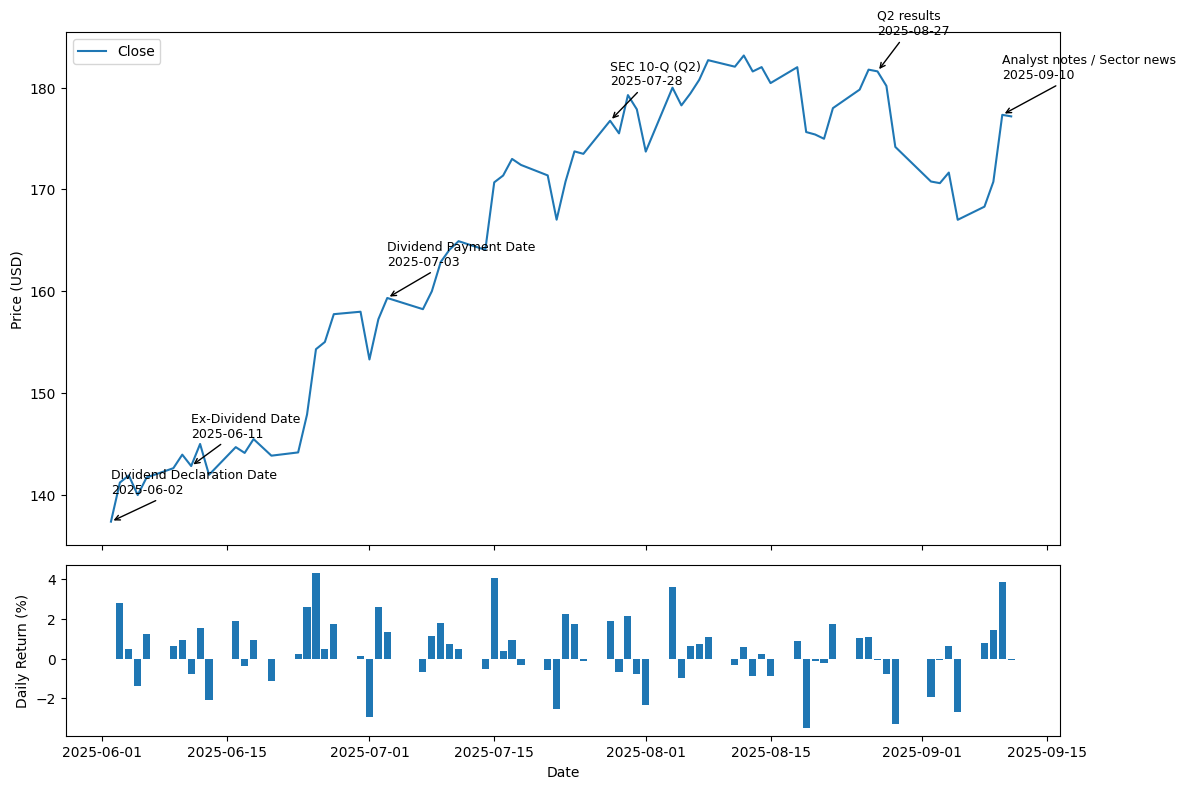

In [142]:
# Annotate the chart with events
event_dates = {
    'Q2 results': '2025-08-27',
    'SEC 10-Q (Q2)': '2025-07-27',
    'Ex-Dividend Date': '2025-09-11',
    'Dividend Payment Date': '2025-07-03',
    'Dividend Declaration Date': '2025-08-27',
    'Ex-Dividend Date': '2025-06-11',
    'Dividend Declaration Date': '2025-05-28',
    'Analyst notes / Sector news': '2025-09-10'
}

fig, ax = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
ax[0].plot(df.index, df['Close'], label='Close')
for label, d in event_dates.items():
    try:
        dt = pd.to_datetime(d)
        if dt in df.index:
            y = df.loc[dt,'Close']
        else:
            # pick nearest trading day
            nearest = df.index.get_indexer([dt], method='nearest')[0]
            y = df.iloc[nearest]['Close']
            dt = df.index[nearest]
        ax[0].annotate(label + '\n' + dt.strftime('%Y-%m-%d'), xy=(dt,y), xytext=(dt,y*1.02),
                      arrowprops=dict(arrowstyle='->'), fontsize=9)
    except Exception as e:
        print('Annotation failed for', label, d, e)

ax[0].set_ylabel('Price (USD)')
ax[0].legend()
ax[1].bar(df.index, df['Return']*100)
ax[1].set_ylabel('Daily Return (%)')
ax[1].set_xlabel('Date')
plt.tight_layout()
plt.show()

#### Possible explanations for price moves in the last 3 months
- **2025-06-11** - Slight drop in price because it is Ex-Dividend Date.
- **2025-07-27 / 2025-04-27** - recent SEC 10-Q filings available on SEC and investor relations pages.
- **2025-08-27** - NVIDIA announced Q2 FY2026 financial results (revenue growth, data center strength).
- **2025-09-10–09-11** - analyst notes / price target moves and sector news (Citi cut target. Oracle jumped by 36% to all-time high. Oracle / AI infrastructure news that benefits GPU demand).

Q2 FY2026 earnings results (Aug 27, 2025): NVIDIA reported $46.7 billion in revenue for the quarter and highlighted strength in its Blackwell data-center products. big revenue/beat and positive commentary about Blackwell data center GPUs likely caused positive moves (or reduced downside) around the earnings date as investors updated revenue and margin expectations. The released Q2 figures and management commentary are directly material to valuation.

Analyst notes & target changes (early Sept 2025): analyst downgrades or target trims (even when ratings remain Buy) can cause short-term intraday/near-term volatility (example: a Citi analyst cut a price target while keeping a Buy rating); conversely, bullish revisions from major houses lift sentiment.

AI infrastructure deals / sector flows (Sept 10–11, 2025): large third-party deals and capex commitments in the AI space (e.g., Oracle’s announced AI spending and deals) can lift Nvidia by signalling persistent GPU demand; these macro/sector headlines often move NVDA even when company-specific news is quiet.

SEC / 10-Q filings and quarterly filings: these detail risks and forward-looking statements that can affect investor sentiment. routine 10-Q filings and risk-factor updates can moderate investor expectations or highlight regulatory/export risk; these items matter especially around quarters when policy (export controls / tariffs) or inventory/reservation items are discussed.

General macro / market flow: broader tech rallies (Fed expectations, risk-on), index re-rating, or other large-cap swings (Oracle/other big moves boosting the S&P/Nasdaq) can amplify NVIDIA’s movement because it’s a large-cap tech leader.

Sector / AI infrastructure news (Sept 10–11, 2025): large AI infrastructure deals and vendor capex guidance (e.g., Oracle’s big AI deals and capex commentary) lifted sentiment for AI chip vendors - often boosting NVIDIA as the leading GPU supplier.

#### References
1. NVIDIA Q2 FY2026 press release (Aug 27, 2025) - revenue and Blackwell data center commentary. https://nvidianews.nvidia.com/news/nvidia-announces-financial-results-for-second-quarter-fiscal-2026
2. NVIDIA Investor Relations - Financial Reports & SEC filings (10-Q forms). https://investor.nvidia.com/financial-info/sec-filings/default.aspx
3. Analyst notes and price-target coverage (examples reported in Yahoo Finance / Reuters / Economic Times). https://finance.yahoo.com/news/analyst-surprisingly-cuts-nvidia-stock-153300571.html
4. Sector news (Oracle AI deals; Barron's coverage) that can influence GPU demand perception. https://www.barrons.com/articles/nvidia-stock-price-ai-chips-925c343f
5. Nvidia news from CNBC - https://www.cnbc.com/2025/08/27/nvidia-nvda-earnings-report-q2-2026.html#:~:text=Earnings%20per%20share%3A%20%241.05%20adjusted,%2446.06%20billion%20estimated